## Autoencoder (AE)

In [ ]:
# all necessary imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/train.csv")
val_data = pd.read_csv("/content/drive/MyDrive/val.csv")
test_data = pd.read_csv("/content/drive/MyDrive/test.csv")

In [ ]:
numerical_cols = ['expected_value', 'price_per_unit', 'number_of_participants',
                      'number_of_disqualifications', 'number_of_questions', 'number_of_requirements',
                      'number_of_complaints', 'number_of_monitorings']
categorical_cols = ['procurement_procedure', 'VAT', 'procedure_status', 'tender_status']

def prepare_data(data, encoder=None, scaler=None, fit=False):
    if fit:
        encoder = OneHotEncoder(drop='first', sparse_output=False)
        encoded_cols = encoder.fit_transform(data[categorical_cols])
    else:
        encoded_cols = encoder.transform(data[categorical_cols])

    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

    result = data.drop(columns=categorical_cols).reset_index(drop=True)
    result = pd.concat([result, encoded_df], axis=1)

    if fit:
        scaler = StandardScaler()
        result[numerical_cols] = scaler.fit_transform(result[numerical_cols])
    else:
        result[numerical_cols] = scaler.transform(result[numerical_cols])

    return result, encoded_df, encoder, scaler


In [ ]:
# Training phase — fit encoder and scaler
train_prepared, _, encoder, scaler = prepare_data(train_data, fit=True)

# Validation and test phase — reuse encoder and scaler
val_prepared, _, _, _ = prepare_data(val_data, encoder=encoder, scaler=scaler)
test_prepared, _, _, _ = prepare_data(test_data, encoder=encoder, scaler=scaler)

final_cols = numerical_cols + list(encoder.get_feature_names_out(categorical_cols))

In [ ]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

class ProcurementDataset(Dataset):
    def __init__(self, data, numerical_cols, categorical_cols, encoder=None, scaler=None, fit=False):
        self.numerical_cols = numerical_cols
        self.categorical_cols = categorical_cols

        # Encode categorical data
        if fit:
            self.encoder = OneHotEncoder(drop='first', sparse_output=False)
            encoded = self.encoder.fit_transform(data[self.categorical_cols])
        else:
            self.encoder = encoder
            encoded = self.encoder.transform(data[self.categorical_cols])

        encoded_df = pd.DataFrame(encoded, columns=self.encoder.get_feature_names_out(self.categorical_cols))

        # Drop original categorical columns
        result = data.drop(columns=self.categorical_cols).reset_index(drop=True)
        result = pd.concat([result, encoded_df], axis=1)

        # Scale numerical columns
        if fit:
            self.scaler = StandardScaler()
            result[self.numerical_cols] = self.scaler.fit_transform(result[self.numerical_cols])
        else:
            self.scaler = scaler
            result[self.numerical_cols] = self.scaler.transform(result[self.numerical_cols])

        self.data = torch.tensor(result[numerical_cols + list(encoded_df.columns)].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def get_encoder_scaler(self):
        return self.encoder, self.scaler

    def get_feature_names(self):
        return self.numerical_cols + list(self.encoder.get_feature_names_out(self.categorical_cols))


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, intermediate_dim=64, latent_dim=16):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, intermediate_dim),
            nn.ReLU(),
            nn.Linear(intermediate_dim, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, intermediate_dim),
            nn.ReLU(),
            nn.Linear(intermediate_dim, input_dim),
            nn.Sigmoid()  # Or remove if input isn't normalized
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# MSE Loss function
def autoencoder_loss(x, x_recon):
    return F.mse_loss(x_recon, x, reduction='sum')

# Training function
def train_autoencoder(model, dataloader, epochs=15, lr=1e-4, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for x_batch in progress_bar:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()
            x_recon = model(x_batch)
            loss = autoencoder_loss(x_batch, x_recon)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
        print(f"Epoch {epoch+1}, Total Loss: {total_loss:.2f}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

numerical_cols = ['expected_value', 'price_per_unit', 'number_of_participants',
                  'number_of_disqualifications', 'number_of_questions', 'number_of_requirements',
                  'number_of_complaints', 'number_of_monitorings']
categorical_cols = ['procurement_procedure', 'VAT', 'procedure_status', 'tender_status']

# Create training dataset (fitting encoder and scaler)
train_dataset = ProcurementDataset(train_data, numerical_cols, categorical_cols, fit=True)
encoder, scaler = train_dataset.get_encoder_scaler()
final_cols = train_dataset.get_feature_names()

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Validation/test datasets (reuse encoder and scaler)
val_dataset = ProcurementDataset(val_data, numerical_cols, categorical_cols, encoder, scaler)
test_dataset = ProcurementDataset(test_data, numerical_cols, categorical_cols, encoder, scaler)

ae = Autoencoder(input_dim=len(final_cols)).to(device)
train_autoencoder(ae, train_loader, device=device)


Epoch 1, Total Loss: 17009631.41


Epoch 2, Total Loss: 15055449.38


Epoch 3, Total Loss: 15012272.25


Epoch 4, Total Loss: 14999540.64


Epoch 5, Total Loss: 14989417.64


Epoch 6, Total Loss: 14985802.21


Epoch 7, Total Loss: 14984244.93


Epoch 8, Total Loss: 14981658.04


Epoch 9, Total Loss: 14980318.49


Epoch 10, Total Loss: 14979409.16


Epoch 11, Total Loss: 14978644.38


Epoch 12, Total Loss: 14977972.31


Epoch 13, Total Loss: 14977504.56


Epoch 14, Total Loss: 14977085.14


Epoch 15, Total Loss: 14976777.16


In [ ]:
ae.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(test_prepared[final_cols].values, dtype=torch.float32).to(device)
    X_test_recon = ae(X_test_tensor)
    reconstruction_errors = torch.mean((X_test_tensor - X_test_recon) ** 2, dim=1).cpu().numpy()


In [ ]:
threshold = np.quantile(reconstruction_errors, 0.9)
anomaly_flags = reconstruction_errors > threshold
print(f"Anomalies detected: {np.sum(anomaly_flags)} out of {len(anomaly_flags)}")

test_prepared['Anomaly'] = anomaly_flags

Anomalies detected: 13080 out of 130796


In [ ]:
from sklearn.metrics import silhouette_score

labels = anomaly_flags.astype(int)

sil_score = silhouette_score(test_prepared[final_cols], labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.6363


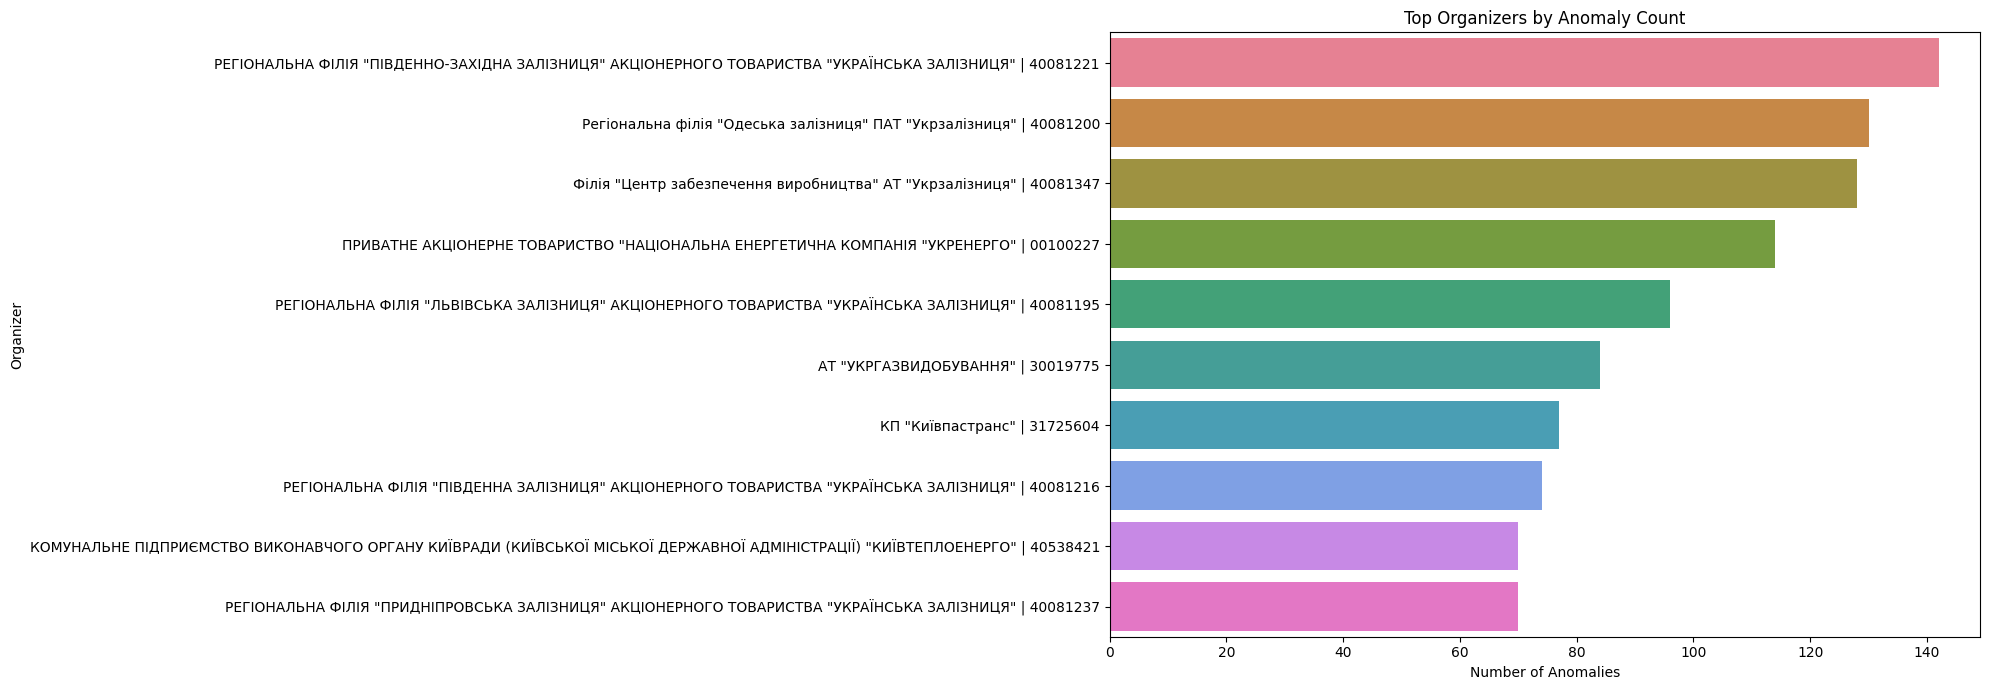

In [ ]:
test_data_with_anomalies = test_data.copy()
test_data_with_anomalies['Anomaly'] = anomaly_flags

anomalies = test_data_with_anomalies[test_data_with_anomalies['Anomaly']]
top_orgs = anomalies['organizer'].value_counts().nlargest(10)
top_orgs_df = top_orgs.reset_index()
top_orgs_df.columns = ['Organizer', 'Anomaly Count']

plt.figure(figsize=(20, 7))
sns.barplot(data=top_orgs_df, x='Anomaly Count', y='Organizer', hue='Organizer', palette='husl')
plt.title("Top Organizers by Anomaly Count")
plt.xlabel("Number of Anomalies")
plt.ylabel("Organizer")
plt.tight_layout()
plt.show()

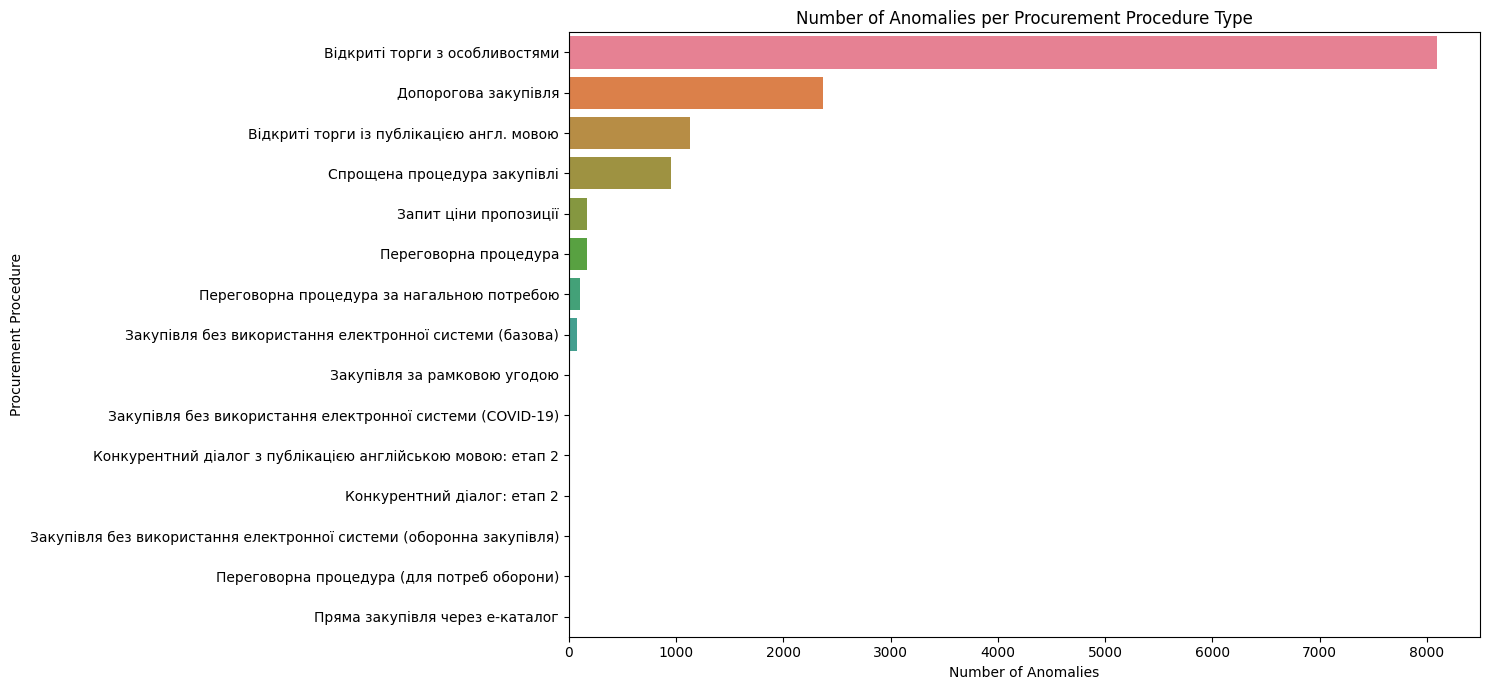

In [ ]:
procurement_cols = [col for col in test_prepared.columns if col.startswith('procurement_procedure_')]
test_prepared['procedure_type'] = test_prepared[procurement_cols].idxmax(axis=1)
test_prepared['procedure_type'] = test_prepared['procedure_type'].str.replace('procurement_procedure_', '', regex=False)

procurement_summary = test_prepared.groupby('procedure_type')['Anomaly'].agg(['count', 'sum'])
procurement_summary['anomaly_ratio'] = procurement_summary['sum'] / procurement_summary['count']
procurement_summary = procurement_summary.sort_values('sum', ascending=False)

plt.figure(figsize=(15, 7))
sns.barplot(
    data=procurement_summary.reset_index(),
    x='sum',
    y='procedure_type',
    hue='procedure_type',
    palette='husl',
    dodge=False,
    legend=False
)
plt.title("Number of Anomalies per Procurement Procedure Type")
plt.xlabel("Number of Anomalies")
plt.ylabel("Procurement Procedure")
plt.tight_layout()
plt.show()


In [ ]:
test_prepared = test_prepared[:50000]
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(test_prepared[final_cols])

test_prepared['TSNE1'] = X_tsne[:, 0]
test_prepared['TSNE2'] = X_tsne[:, 1]

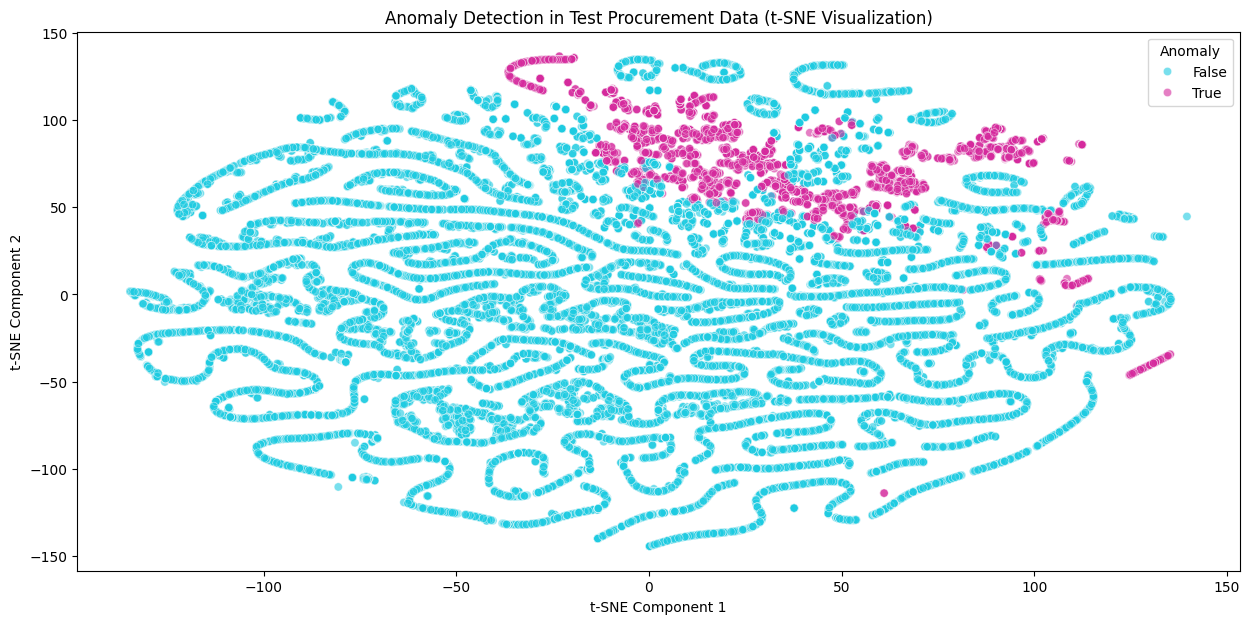

In [ ]:
plt.figure(figsize=(15, 7))
sns.scatterplot(data=test_prepared, x='TSNE1', y='TSNE2', hue='Anomaly', palette={True: '#d52a9d', False: '#1ecbe1'}, alpha=0.6)
plt.title("Anomaly Detection in Test Procurement Data (t-SNE Visualization)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Anomaly")
plt.show()